# Analyzing pathways and controls
This example demonstrates Connectome Utilities functions to turn a simple "atomic" analysis into something more complex, by automatically applying it to discrete or overlapping populations. Additionally, it demonstrates the ability to handle control models and compare the results of an analysis between control and data.


We begin by loading data. In this example, we load neuron-to-neuron connectivity of a few thousand neurons in a biologically detailed model. It also loads a list of "properties" associated with the nodes (neurons), such as their locations in two different coordinate systems.

We demonstrate how the data would be loaded from a circuit model in Sonata format, but in case you don't have a Sonata circuit available, there is also a serialized version provided with this repository.

In [1]:
import numpy, pandas
import bluepysnap as snap
import conntility
import os

from scipy.spatial import distance
from matplotlib import pyplot as plt


# Describes which node properties to load and filtering based on them
# This loads a small subvolume of aorund 6.5k nodes
load_cfg = {
    "loading":{    
        "properties": ["x", "y", "z", "mtype", "layer", "synapse_class"],
        "atlas": [
            {
                "data": "./data/ss_fm.nrrd", 
                "properties": ["ss_flat_x", "depth", "ss_flat_y"]
            }
        ],
        "base_target": "hex_O1",
        "node_population": "S1nonbarrel_neurons"
    },
    "filtering":[
        {
            "column": "synapse_class",
            "values": ["EXC"]
        },
        {
            "column": "layer",
            "values": [2, 3]
        },
        {
            "column": "ss_flat_x",
            "interval": [1200, 1600]
        },
        {
            "column": "ss_flat_y",
            "interval": [2300, 2700]
        }
    ]
}

# Some additional configuration
fn_circ = "./data/circuit_config_multipop.json"
fn_con_mat = "./data/L23_EXC_sampled_cmat.h5"
population = 'S1nonbarrel_neurons__S1nonbarrel_neurons__chemical'

# Since you may not have access to the Sonata circuit this example is based on, we provide the result also in hdf5
if os.path.exists(fn_con_mat):
    cmat = conntility.ConnectivityMatrix.from_h5(fn_con_mat)
else:
    circ = snap.Circuit(fn_circ)
    cmat = conntility.ConnectivityMatrix.from_bluepy(circ, load_config=load_cfg, population=population,
                                                    connectome="S1nonbarrel_neurons__S1nonbarrel_neurons__chemical")
    cmat.to_h5(fn_con_mat)

100%|██████████| 6439/6439 [00:23<00:00, 271.41it/s]


For analysis, of course it is possible to run whatever code we want on the adjacency matrix

Text(0, 0.5, 'Count')

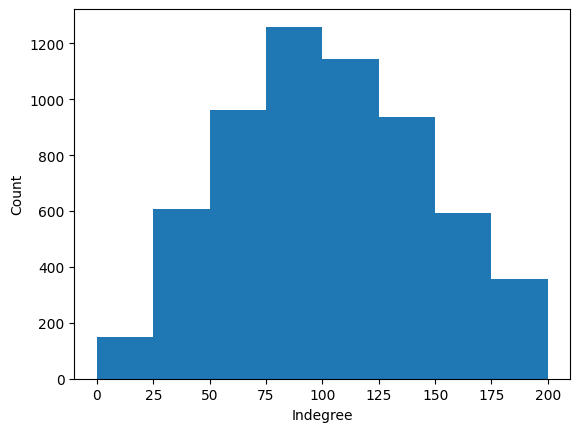

In [2]:
indeg_bins = [0, 25, 50, 75, 100, 125, 150, 175, 200]

H = numpy.histogram(cmat.matrix.sum(axis=0), bins=indeg_bins)[0]
plt.bar(indeg_bins[:-1], H, width=25, align="edge")
plt.gca().set_xlabel("Indegree")
plt.gca().set_ylabel("Count")

But for more complex analyses we would codify the details in an _analysis configuration_ file.
Note that the actual underlying analysis is typically not part of the Connectome Utilities but assumed to exist in a python file or package somewhere else. Connectome Utilities just provides the means to execute the analysis efficiently for separate subnetworks, or generate controls and compare to them.

We will begin by running a primitive analysis on the network. It is dynamically imported from a python file. Since this is just an example, we write that file to contain a primitive analysis counting the number of connections.

In [3]:
with open("simple_analysis_example.py", "w") as fid:
    fid.write("""
def count_connections(mat, nrn):
    return mat.nnz

"""
             )
analysis_specs = {
    "analyses":{
        "connection_counts": {
            "source": "simple_analysis_example.py",
            "method": "count_connections",
            "output": "scalar"
        }
    }
}
cmat.analyze(analysis_specs)


{'connection_counts': 713949}

This was very primitive and hardly worth writing a configuration for.
But we can perform much more involved analyses by stacking decorators onto the base analysis.

For example, we can analyze different subpopulations separately. 
To do this, we specify the name of the node property to use to define the groups. In the first example, we will use the "mtype" property and the resulting groups will be all unique values of that property.

The sub-matrices to be analyzed separately as a result can be defined in several different ways. Let M be the matrix and g be a group. Then:

"grouped_presyn_by_grouping_config" analyses separately the M[g, :]

"grouped_postsyn_by_grouping_config" analyses separately the M[:, g]

"grouped_subpop_by_grouping_config" analyses separately the M[numpy.ix_(g, g)]


In [4]:
analysis_specs = {
    "analyses":{
        "connection_counts_from_type": {
            "source": "simple_analysis_example.py",
            "method": "count_connections",
            "output": "scalar",
            "decorators": [
                {
                    "name": "grouped_presyn_by_grouping_config",
                    "args": [{"columns": ["mtype"], "method": "group_by_properties"}]
                }
            ]
        },
        "connection_counts_to_type": {
            "source": "simple_analysis_example.py",
            "method": "count_connections",
            "output": "scalar",
            "decorators": [
                {
                    "name": "grouped_postsyn_by_grouping_config",
                    "args": [{"columns": ["mtype"], "method": "group_by_properties"}]
                }
            ]
        },
        "connection_counts_within_type": {
            "source": "simple_analysis_example.py",
            "method": "count_connections",
            "output": "scalar",
            "decorators": [
                {
                    "name": "grouped_subpop_by_grouping_config",
                    "args": [{"columns": ["mtype"], "method": "group_by_properties"}]
                }
            ]
        }
    }
}
cmat.analyze(analysis_specs)

{'connection_counts_from_type': idx-mtype
 L2_IPC       23930
 L2_TPC:A     24504
 L2_TPC:B    278268
 L3_TPC:A    295004
 L3_TPC:C     92243
 dtype: int64,
 'connection_counts_within_type': idx-mtype
 L2_IPC         861
 L2_TPC:A       951
 L2_TPC:B    110767
 L3_TPC:A    185844
 L3_TPC:C     14422
 dtype: int64,
 'connection_counts_to_type': idx-mtype
 L2_IPC       19011
 L2_TPC:A     18926
 L2_TPC:B    197216
 L3_TPC:A    382067
 L3_TPC:C     96729
 dtype: int64}

Simimlarly, "pathways_by_grouping_config" analyses separately the M[a, b] for all pairs of groups a, b.
Also note that more than one property ("column") can be provided. In that case, the groups are given by the cartesian product of the values of the two properties.

In [5]:
analysis_specs = {
    "analyses":{
        "connection_counts_for_pathways": {
            "source": "simple_analysis_example.py",
            "method": "count_connections",
            "output": "scalar",
            "decorators": [
                {
                    "name": "pathways_by_grouping_config",
                    "args": [{"columns": ["mtype"], "method": "group_by_properties"}]
                }
            ]
        }
    }
}
cmat.analyze(analysis_specs)

{'connection_counts_for_pathways': idx-mtype_pre  idx-mtype_post
 L2_IPC         L2_IPC               861
 L2_TPC:A       L2_IPC               891
 L2_TPC:B       L2_IPC              8220
 L3_TPC:A       L2_IPC              7009
 L3_TPC:C       L2_IPC              2030
 L2_IPC         L2_TPC:A            1083
 L2_TPC:A       L2_TPC:A             951
 L2_TPC:B       L2_TPC:A           10740
 L3_TPC:A       L2_TPC:A            4375
 L3_TPC:C       L2_TPC:A            1777
 L2_IPC         L2_TPC:B            9839
 L2_TPC:A       L2_TPC:B           10125
 L2_TPC:B       L2_TPC:B          110767
 L3_TPC:A       L2_TPC:B           47362
 L3_TPC:C       L2_TPC:B           19123
 L2_IPC         L3_TPC:A            9939
 L2_TPC:A       L3_TPC:A           10222
 L2_TPC:B       L3_TPC:A          121171
 L3_TPC:A       L3_TPC:A          185844
 L3_TPC:C       L3_TPC:A           54891
 L2_IPC         L3_TPC:C            2208
 L2_TPC:A       L3_TPC:C            2315
 L2_TPC:B       L3_TPC:C         

The above was defining groups by node properties that have discrete values. What if the values are numerical?
We can ask them to be binned and the resulting bins used as groups. Or, for spatial coordinates, we can define a hexagonal grid that determines the groups; this requires locgically two coordinates ("columns").


In [6]:
analysis_specs = {
    "analyses":{
        "connection_counts_by_depth": {
            "source": "simple_analysis_example.py",
            "method": "count_connections",
            "output": "scalar",
            "decorators": [
                {
                    "name": "grouped_subpop_by_grouping_config",
                    "args": [{"columns": ["depth"],
                              "method": "group_by_binned_properties",
                             "args": [numpy.arange(0, 550, 50)]}]
                }
            ]
        },
        "connection_counts_in_grid": {
            "source": "simple_analysis_example.py",
            "method": "count_connections",
            "output": "scalar",
            "decorators": [
                {
                    "name": "grouped_subpop_by_grouping_config",
                    "args": [
                        {
                            "columns": ["ss_flat_x", "ss_flat_y"],
                            "method": "group_by_grid",
                            "args": [75]
                        }
                    ]
                }
            ]
        }
    }
}
cmat.analyze(analysis_specs)

/gpfs/bbp.cscs.ch/home/reimann/venvs/bpsnap/lib/python3.10/site-packages/conntility/analysis/analysis_decorators.py:66: PerformanceWarning: indexing past lexsort depth may impact performance.
  ret = [analysis_function(submatrices[ix], grouped.loc[ix], *args, **kwargs) for ix in idxx]


{'connection_counts_by_depth': binned-depth
 2        36
 3      5704
 4     25704
 5      3770
 6     14839
 7      9752
 8      7859
 9      8245
 10     3530
 11    61975
 dtype: int64,
 'connection_counts_in_grid': grid-i  grid-j
 -21     42        16723
 -26     46         4172
 -22     47         2556
 -23     46        21115
 -20     43        18384
 -25     47         7374
 -24     42         1057
         45        17752
 -22     44        18772
 -25     44        15169
 -20     40          414
 -21     45        16932
 -22     41        11327
 -19     41          190
         44         2671
 -24     48         2932
 -23     43        14936
 -18     42          171
 -27     45          238
 dtype: int64}

The hex grid is integer indexed. If you want to know the location of the hexes and which neurons belong to it, you can call
the grouping function directly on the vertices of the ConnectivityMatrix object. With the same "grouping config".

,,node_ids,layer,mtype,synapse_class,x,y,z,ss_flat_x,depth,ss_flat_y,grid-x,grid-y,grid-subtarget
grid-i,grid-j,,,,,,,,,,,,,
-21,42,473,3,L3_TPC:A,EXC,4256.445983,-1436.201655,-1996.809993,1311.912084,442.801146,2396.795206,1363.990011,2362.5,R21;C10
-26,46,476,3,L3_TPC:A,EXC,4227.915526,-1218.248226,-1768.799540,1330.236605,303.611683,2680.408345,1299.038106,2700.0,R24;C10
-22,47,480,3,L3_TPC:A,EXC,4408.956738,-1135.949989,-2021.862122,1596.134933,425.296817,2608.081314,1623.797632,2587.5,R23;C12
-23,46,498,3,L3_TPC:A,EXC,4265.085830,-1152.106429,-1973.665199,1461.707215,479.018818,2622.434042,1493.893822,2587.5,R23;C11
-20,43,503,3,L3_TPC:A,EXC,4375.797338,-1368.977633,-2091.973131,1508.219517,418.241594,2377.690836,1493.893822,2362.5,R21;C11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
-22,41,170495,2,L2_TPC:B,EXC,4294.609723,-1559.971857,-1775.832886,1202.835981,250.657708,2346.407765,1234.086200,2362.5,R21;C9
-21,42,170506,2,L2_TPC:B,EXC,4457.700723,-1486.472723,-1776.674450,1361.817336,107.428580,2366.728087,1363.990011,2362.5,R21;C10
-24,48,170541,2,L2_TPC:B,EXC,4406.124331,-1111.820575,-1808.572521,1525.197069,190.957913,2681.608957,1558.845727,2700.0,R24;C12


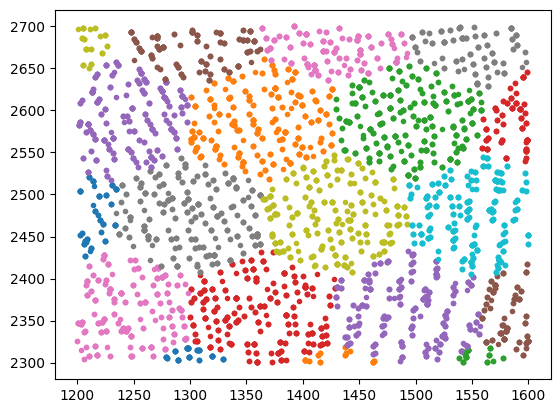

In [7]:
grp_cfg = {
    "columns": ["ss_flat_x", "ss_flat_y"],
    "method": "group_by_grid",
    "args": [75]
}
nrn = conntility.circuit_models.neuron_groups.group_with_config(cmat.vertices, grp_cfg)
display(nrn) # Index determined the groups

_ = nrn.groupby("grid-subtarget").apply(lambda x: plt.plot(x["ss_flat_x"], x["ss_flat_y"], '.'))

An even more complex way of determining subpopulations is by using "filter configurations" instead.
Just as "grouping configurations", they determine subpopulations based on node properties, but in a different way. Instead of using all possible values, or binned values, they specify a list of filters that a node must pass in order to be considered part of the group.

In the example below, we define two groups: One of "L3_TPC:A" and "L2_TPC:B" neurons with depths between 100 and 300; another of the same types with depths between 300 and 500.

In [8]:
lst_decorator = [
    {
        "name": "grouped_population_by_filtering_config",
        "args": [
            [{
                "filtering": [
                    {
                        "column": "depth",
                        "interval": [100, 300]
                    },
                    {
                        "column": "mtype",
                        "values": ["L3_TPC:A", "L2_TPC:B"]
                    }
                ]
            },
            {
                "filtering": [
                    {
                        "column": "depth",
                        "interval": [300, 500]
                    },
                    {
                        "column": "mtype",
                        "values": ["L3_TPC:A", "L2_TPC:B"]
                    }
                ]
            }]
        ]
    }
]

analysis_specs = {
    "analyses":{
        "connection_counts": {
            "source": "simple_analysis_example.py",
            "method": "count_connections",
            "output": "scalar",
            "decorators": lst_decorator
        }
    }
}
cmat.analyze(analysis_specs)

{'connection_counts': depth       mtype                   
 [100, 300]  ['L3_TPC:A', 'L2_TPC:B']    121370
 [300, 500]  ['L3_TPC:A', 'L2_TPC:B']     64396
 dtype: int64}

## Control with random matrices
We might want to compare the results of the analysis to a control. 
To that end, we write a control function that takes a matrix and list of node properties as input and returns a randomized matrix according to some control model. Here we use a very, very primitive model.

Connectome Utilities takes care of running the randomization analzing the results and returning them to the user. This is done by another decorator.

Note that in this case we do not expect significant differences between data and control.

In [9]:
from scipy import sparse

def primitive_er(M, *args):
    return sparse.csc_matrix(numpy.random.rand(*M.shape) < M.mean())

analysis_specs = {
    "analyses":{
        "connection_counts_for_pathways": {
            "source": "simple_analysis_example.py",
            "method": "count_connections",
            "output": "scalar",
            "decorators": [
                {
                    "name": "control_by_randomization",
                    "args": [primitive_er],
                    "kwargs": {"n_randomizations": 5, "only_mean": False}
                }
            ]
        }
    }
}
cmat.analyze(analysis_specs)


{'connection_counts_for_pathways': Control     Instance
 data        0           713949
 randomized  0           715125
             1           714957
             2           713968
             3           713476
             4           711029
 dtype: int64}

Once again, the code for the randomization can be dynamically imported from a python file. This works as follows:

In [10]:
with open("primitive_er.py", "w") as fid:
    fid.write("""
from scipy import sparse
import numpy

def primitive_er(M, *args):
    return sparse.csc_matrix(numpy.random.rand(*M.shape) < M.mean())
""")
    
analysis_specs = {
    "analyses":{
        "connection_counts_for_pathways": {
            "source": "simple_analysis_example.py",
            "method": "count_connections",
            "output": "scalar",
            "decorators": [
                {
                    "name": "control_by_randomization",
                    "analysis_arg":
                    {
                        "random_er":{
                            "source": "primitive_er.py",
                            "method": "primitive_er",
                            "args": [],
                            "kwargs": {},
                            "output": "Matrix"
                        }
                    },
                    "args": [],
                    "kwargs": {"n_randomizations": 5, "only_mean": False}
                }
            ]
        }
    }
}
cmat.analyze(analysis_specs)

{'connection_counts_for_pathways': Control    Instance
 data       0           713949
 random_er  0           713557
            1           714521
            2           714652
            3           713489
            4           713842
 dtype: int64}

## Combining decorators

Note that decorators can be combined and chained.
We can analyze "pathways" separately and also combine results to controls.

In [11]:
analysis_specs = {
    "analyses":{
        "connection_counts_for_pathways": {
            "source": "simple_analysis_example.py",
            "method": "count_connections",
            "output": "scalar",
            "decorators": [
                {
                    "name": "pathways_by_grouping_config",
                    "args": [{"columns": ["mtype"], "method": "group_by_properties"}]
                },
                {
                    "name": "control_by_randomization",
                    "analysis_arg":
                    {
                        "random_er":{
                            "source": "primitive_er.py",
                            "method": "primitive_er",
                            "args": [],
                            "kwargs": {},
                            "output": "Matrix"
                        }
                    },
                    "args": [],
                    "kwargs": {"n_randomizations": 5, "only_mean": False}
                }
            ]
        }
    }
}
cmat.analyze(analysis_specs)

{'connection_counts_for_pathways': Control    Instance  idx-mtype_pre  idx-mtype_post
 data       0         L2_IPC         L2_IPC              861
                      L2_TPC:A       L2_IPC              891
                      L2_TPC:B       L2_IPC             8220
                      L3_TPC:A       L2_IPC             7009
                      L3_TPC:C       L2_IPC             2030
                                                       ...  
 random_er  4         L2_IPC         L3_TPC:C           2619
                      L2_TPC:A       L3_TPC:C           4632
                      L2_TPC:B       L3_TPC:C          31322
                      L3_TPC:A       L3_TPC:C          41486
                      L3_TPC:C       L3_TPC:C          11972
 Length: 150, dtype: int64}

When combining decorators, their order matters! In the example above, first the matrix is broken up into submatrices, which are then separately randomized by the control script.

If we swap their order, then first the entire matrix is randomized, and then broken up into "pathways".

In [12]:
analysis_specs = {
    "analyses":{
        "connection_counts_for_pathways": {
            "source": "simple_analysis_example.py",
            "method": "count_connections",
            "output": "scalar",
            "decorators": [
                {
                    "name": "control_by_randomization",
                    "analysis_arg":
                    {
                        "random_er":{
                            "source": "primitive_er.py",
                            "method": "primitive_er",
                            "args": [],
                            "kwargs": {},
                            "output": "Matrix"
                        }
                    },
                    "args": [],
                    "kwargs": {"n_randomizations": 5, "only_mean": True}
                },
                {
                    "name": "pathways_by_grouping_config",
                    "args": [{"columns": ["mtype"], "method": "group_by_properties"}]
                }
            ]
        }
    }
}
cmat.analyze(analysis_specs)

AttributeError: 'tuple' object has no attribute 'shape'